## This notebook utilizes the tool to make a refine-sample-coarsen model topography 

In [1]:
import GMesh
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

## GridMesh Class

## Read GEBCO dataset for topography

In [2]:
# Read topo data
#! cp -n /archive/gold/datasets/topography/GEBCO_2023/GEBCO_2023.nc .
#! ln -s /home/Niki.Zadeh/datasets .datasets
with netCDF4.Dataset('.datasets/GEBCO_2020.nc') as nc:
    topo_lons = nc.variables['lon'][:].filled(0.)
    topo_lats = nc.variables['lat'][:].filled(0.)
    topo_elvs = nc.variables['elevation'][:,:].filled(0.)

In [3]:
src_topo_global = GMesh.UniformEDS( topo_lons, topo_lats, topo_elvs )
src_topo_global

<UniformEDS 86400 x 43200 (27.810Gb)
lon = <RegularCoord n=86400, dx=0.004166666666666667, rdx=240.0, x0=-180.0, io=-43200, rem=0.0, is-ie=0-86400, periodic=True>
h:[-179.99791667 -179.99375    -179.98958333 ...  179.98958333  179.99375
  179.99791667]
q:[-180.         -179.99583333 -179.99166667 ...  179.99166667  179.99583333
  180.        ]
lat = <RegularCoord n=43200, dx=0.004166666666666667, rdx=240.0, x0=-90, io=-21600, rem=0.0, is-ie=0-43200, periodic=False>
h:[-89.99791667 -89.99375    -89.98958333 ...  89.98958333  89.99375
  89.99791667]
q:[-90.         -89.99583333 -89.99166667 ...  89.99166667  89.99583333
  90.        ]
data = (43200, 86400)>

In [4]:
print(' topography grid array shapes: ' , topo_lons.shape,topo_lats.shape,topo_elvs.shape)
print(' topography longitude range:',topo_lons.min(),topo_lons.max())
print(' topography latitude range:',topo_lats.min(),topo_lats.max())
print(' Is mesh uniform?', GMesh.is_mesh_uniform( topo_lons, topo_lats ) )
#GEBCO_2014_2D.nc
# topography grid array shapes:  (43200,) (21600,) (21600, 43200)
# topography longitude range: -299.995833333 59.9958333333
# topography latitude range: -89.9958333333 89.9958333333
# Is mesh uniform? True
#GEBCO_2020.nc
# topography grid array shapes:  (86400,) (43200,) (43200, 86400)
# topography longitude range: -299.9979166666667 59.99791666666667
# topography latitude range: -89.99791666666667 89.99791666666667
# Is mesh uniform? True

 topography grid array shapes:  (86400,) (43200,) (43200, 86400)
 topography longitude range: -179.99791666666667 179.99791666666667
 topography latitude range: -89.99791666666667 89.99791666666667
 Is mesh uniform? True


## Read the target grid

Terget grid is the underlying finite element 2D supergrid to be used in the Ocean model. Here we choose a 1/4 degree Mercator grid  generated by using the [grid_generation tool](https://github.com/nikizadehgfdl/grid_generation). 

In [5]:
# Read target mesh
#!cp -n /archive/bgr/Datasets/OM5/topo_v4/OM5_025/ocean_hgrid.nc OM5_ocean_hgrid.nc
#! ln -s /home/Niki.Zadeh/datasets .datasets
with netCDF4.Dataset('.datasets/ocean_hgrid.Merc.4deg.nc') as nc:
    targG = GMesh.GMesh( lon=nc.variables['x'][::2,::2], lat=nc.variables['y'][::2,::2] )
targG

<GMesh nj:43 ni:90 shape:(43,90)>

In [6]:
GMesh.pfactor( targG.ni ), GMesh.pfactor( targG.nj )

([5, 3, 3, 2], [43])

In [7]:
targG.lon.shape,targG.lon[0,0]

((44, 91), -300.0)

In [8]:
#import create_topog_refinedSampling as topotool
#jllc,illc,status1=topotool.get_indices1D(topo_lons, topo_lats ,targG.lon[0,0] ,targG.lat[0,0])
#jurc,iurc,status2=topotool.get_indices1D(topo_lons, topo_lats ,targG.lon[0,-1],targG.lat[-1,0])

In [9]:
def convol( levels, h, f, verbose=False ):
    """Coarsens the product of h*f across all levels"""
    levels[-1].height = ( h * f ).reshape(levels[-1].nj,levels[-1].ni)
    for k in range( len(levels) - 1, 0, -1 ):
        if verbose: print('Coarsening {} -> {}'.format(k,k-1))
        levels[k].coarsenby2( levels[k-1] )
    return levels[0].height  

def rough( levels, h, h2min=1.e-7 ):
    """Calculates both mean of H, and variance of H relative to a plane"""
    # Construct weights for moment calculations
    nx = 2**( len(levels) - 1 )
    x = ( np.arange(nx) - ( nx - 1 ) /2 ) * np.sqrt( 12 / ( nx**2 - 1 ) ) # This formula satisfies <x>=0 and <x^2>=1
    X, Y = np.meshgrid( x, x )
    X, Y = X.reshape(1,nx,1,nx), Y.reshape(1,nx,1,nx)
    h = h.reshape(levels[0].nj,nx,levels[0].ni,nx)
    # Now calculate moments
    H2 = convol( levels, h, h ) # mean of h^2
    HX = convol( levels, h, X ) # mean of h * x
    HY = convol( levels, h, Y ) # mean of h * y
    H = convol( levels, h, np.ones((1,nx,1,nx)) ) # mean of h = mean of h * 1
    # The variance of deviations from the plane = <h^2> - <h>^2 - <h*x>^2 - <h*y>^2 given <x>=<y>=0 and <x^2>=<y^2>=1
    return H, H2 - H**2 - HX**2 - HY**2 + h2min


In [10]:
def do_RSC_new(targG,src_topo_global,NtileI=1, NtileJ=1, max_refinement=10):
    """Apply the RSC algoritm using a fixed number of refinements max_refinement"""
    di, dj = targG.ni // NtileI, targG.nj // NtileJ
    assert di*NtileI == targG.ni
    assert dj*NtileJ == targG.nj
    print('window size dj,di =',dj,di,'full model nj,ni=',targG.nj, targG.ni)
    Hcnt = np.zeros((targG.nj, targG.ni)) # Diagnostic: counting which cells we are working on
    Htarg, H2targ = np.zeros((targG.nj, targG.ni)), np.zeros((targG.nj, targG.ni))
    for j in range(NtileJ ):
        csj, sj = slice( j*dj, (j+1)*dj ), slice( j*dj, (j+1)*dj+1 )
        for i in range(NtileI ):
            csi, si = slice( i*di, (i+1)*di ), slice( i*di, (i+1)*di+1 ) # Slices of target grid
            Hcnt[csj,csi] = Hcnt[csj,csi] + 1 # Diagnostic: counting which cells we are working on
            G = GMesh.GMesh( lon=targG.lon[sj,si], lat=targG.lat[sj,si] )
            print('J,I={},{} {:.1f}%, {}\n   window lon={}:{}, lat={}:{}\n   jslice={}, islice={}'.format( \
                j, i, 100*(j*NtileI+i)/(NtileI*NtileJ), G, G.lon.min(), G.lon.max(), G.lat.min(), G.lat.max(), sj, si ))
            levels = G.refine_loop( src_topo_global, resolution_limit=True, fixed_refine_level=max_refinement, timers=False )
            ## Use nearest neighbor topography to populate the finest grid
            levels[-1].project_source_data_onto_target_mesh( src_topo_global )
            ## Now recursively coarsen
            h, h2 = rough( levels, levels[-1].height )
            # Store window in final array
            Htarg[csj,csi] = h
            H2targ[csj,csi] = h2
    print( Hcnt.min(), Hcnt.max(), '<-- should both be 1 for full model' )
    return  Htarg, H2targ
    
st = time.time()
NtileI, NtileJ, max_refinement = 1, 1, 9
Htarg, H2targ = do_RSC_new(targG,src_topo_global,NtileI, NtileJ, max_refinement)    
et = time.time() - st
print('Execution time:', et, 'seconds')

#refmax=9  Hit 33816576   out of  89616960  cells,  37.7345716703624    percent  Execution time: 581.8026268482208 seconds
#refmax=10 Hit 135266304  out of  89619840  cells,  150.93343616770574  percent Execution time: 2316.814207315445 seconds
#refmax=10 Refined grid resolution is less than source grid resolution.
#After every refinement the number of hits increases by a factor of 4 (almost). 
#So when more than 25% is hit, upon a refinement the resolution of refined grid becomes more than the resolution of the source and each source point
#gets hit multiple times and the algorithm should be considered as converged.

window size dj,di = 43 90 full model nj,ni= 43 90
J,I=0,0 0.0%, <GMesh nj:43 ni:90 shape:(43,90)>
   window lon=-300.0:60.0, lat=-66.51326044311185:63.11375440256549
   jslice=slice(0, 44, None), islice=slice(0, 91, None)
Refine level 0 <GMesh nj:43 ni:90 shape:(43,90)>
Refine level 1 <GMesh nj:86 ni:180 shape:(86,180)>
Refine level 2 <GMesh nj:172 ni:360 shape:(172,360)>
Refine level 3 <GMesh nj:344 ni:720 shape:(344,720)>
Refine level 4 <GMesh nj:688 ni:1440 shape:(688,1440)>


Refine level 5 <GMesh nj:1376 ni:2880 shape:(1376,2880)>
Refine level 6 <GMesh nj:2752 ni:5760 shape:(2752,5760)>
Refine level 7 <GMesh nj:5504 ni:11520 shape:(5504,11520)>
Refine level 8 <GMesh nj:11008 ni:23040 shape:(11008,23040)>
Refine level 9 <GMesh nj:22016 ni:46080 shape:(22016,46080)>
 Hit 1014497280  out of  2688508800  cells,  37.7345716703624  percent
1.0 1.0 <-- should both be 1 for full model
Execution time: 570.3425149917603 seconds


In [11]:
Htarg.min(),Htarg.max(),Htarg.mean(),Htarg.std(),H2targ.min(),H2targ.max(),H2targ.mean(),H2targ.std()
#torch cpu
#(-6005.377197265625, 5070.655120849609, -2577.601876764026, 2298.68199945539,
# 15.688113937212114, 3949765.575778824, 2

(-6005.337509155273,
 5070.545104980469,
 -2577.6039347922156,
 2298.682372598141,
 15.510816403361877,
 3949965.2469336865,
 215026.79636041223,
 391356.77281429834)

In [12]:
with netCDF4.Dataset('new_topo_OM5_grid_r{}_{}x{}.nc'.format(max_refinement, NtileI, NtileJ),'w','clobber') as nc:
    nx = nc.createDimension('nx', Htarg.shape[1])
    ny = nc.createDimension('ny', Htarg.shape[0])
    ntiles = nc.createDimension('ntiles', 1)
    z = nc.createVariable('depth', float, ('ny','nx') )
    z.units='meters'
    z2 = nc.createVariable('h2', float, ('ny','nx'))
    z2.units='meters^2'
    z[:,:] = -Htarg[:,:]
    z2[:,:] = H2targ[:,:]

In [13]:
#plt.pcolormesh( targG.lon, targG.lat, Htarg ); plt.colorbar();

In [14]:
!ls new_topo*

new_topo_OM5_grid_r9_1x1.nc


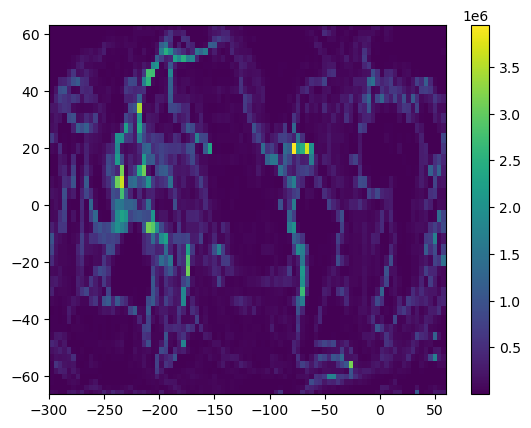

In [15]:
with netCDF4.Dataset('new_topo_OM5_grid_r{}_{}x{}.nc'.format(max_refinement, NtileI, NtileJ)) as nc:
    roughness = nc.variables['h2'][:,:]
plt.pcolormesh( targG.lon, targG.lat, roughness ); plt.colorbar();    

In [16]:
#depth_r6_30x1 = netCDF4.Dataset('new_topo_OM5_grid_r6_30x1.nc').variables['depth'][:,:]
#depth_r9_30x1 = netCDF4.Dataset('new_topo_OM5_grid_r9_30x1.nc').variables['depth'][:,:]
#depth_r10_30x1 = netCDF4.Dataset('new_topo_OM5_grid_r10_30x1.nc').variables['depth'][:,:]
#plt.pcolormesh( targG.lon, targG.lat, depth_r9_30x1-depth_r10_30x1 ); plt.colorbar(); 